Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,778 (471.79 KB)

 Trainable params: 120,778 (471.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0228 - val_loss: 0.0028
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

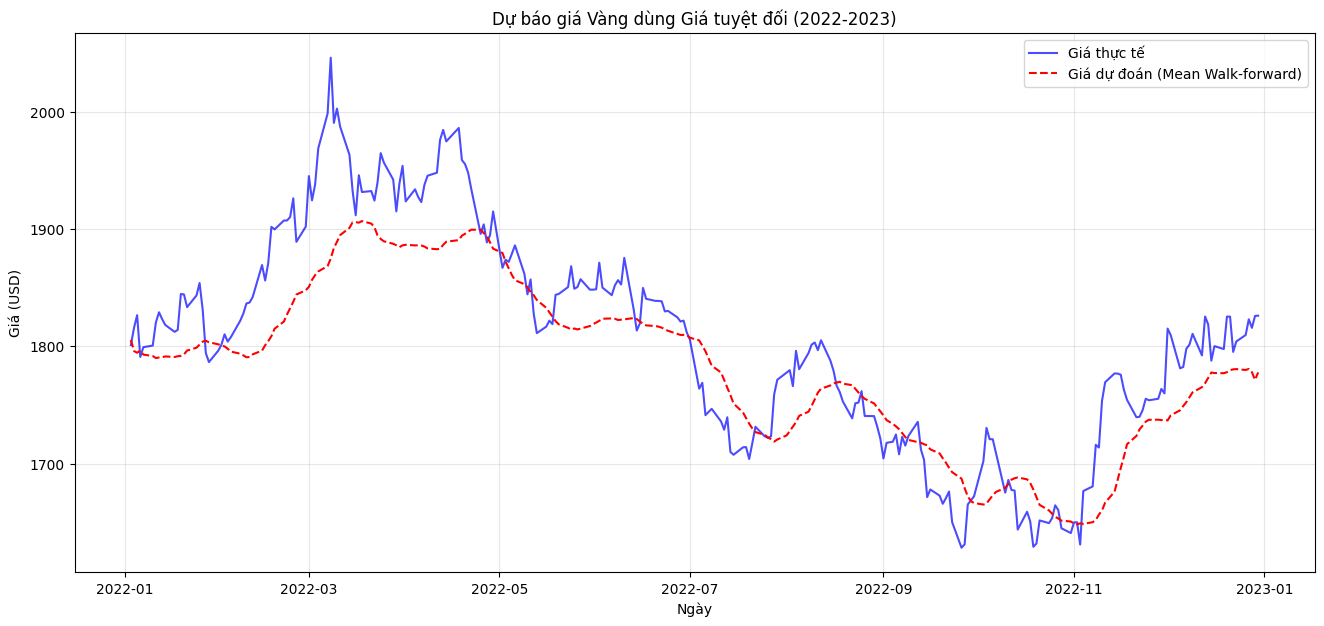

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import keras
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout

# ==========================================
# 1. CẤU HÌNH VÀ LOAD DỮ LIỆU
# ==========================================
WINDOW_SIZE = 60  # Dùng 60 ngày quá khứ
HORIZON = 10      # Dự đoán 10 ngày tiếp theo

df = pd.read_csv('Gold Price (2013-2023).csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Làm sạch dữ liệu số (loại bỏ dấu phẩy)
for col in ['Price', 'Open', 'High', 'Low']:
    if df[col].dtype == 'O':
        df[col] = df[col].str.replace(',', '').astype(float)

# ==========================================
# 2. CHUẨN BỊ FEATURES (DÙNG GIÁ TRỊ TUYỆT ĐỐI)
# ==========================================
X_all = []
Y_all = []
dates_all = []

price_values = df['Price'].values
date_values = df['Date'].values

for i in range(WINDOW_SIZE, len(df) - HORIZON + 1):
    # X là chuỗi giá 60 ngày liên tiếp
    X_all.append(price_values[i-WINDOW_SIZE:i])
    # Y là chuỗi giá 10 ngày tiếp theo
    Y_all.append(price_values[i:i+HORIZON])
    dates_all.append(date_values[i:i+HORIZON])

X_all = np.array(X_all).reshape(-1, WINDOW_SIZE, 1)
Y_all = np.array(Y_all)

# ==========================================
# 3. CHIA TRAIN/TEST & SCALING
# ==========================================
# Tách dữ liệu Test từ năm 2022
test_start_idx = df[df['Date'].dt.year >= 2022].index[0] - WINDOW_SIZE
X_train, X_test = X_all[:test_start_idx], X_all[test_start_idx:]
y_train, y_test = Y_all[:test_start_idx], Y_all[test_start_idx:]
dates_test = dates_all[test_start_idx:]

# Scaler cho Features (Giá tuyệt đối)
scaler_x = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_x.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test_scaled = scaler_x.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Scaler cho Target (Giá tuyệt đối)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)

# ==========================================
# 4. XÂY DỰNG MODEL LSTM
# ==========================================
def build_model():
    inputs = Input(shape=(WINDOW_SIZE, 1))
    
    # Layer 1
    x = LSTM(units=128, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    
    # Layer 2
    x = LSTM(units=64, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    
    # Fully Connected
    x = Dense(64, activation='relu')(x)
    outputs = Dense(HORIZON)(x) # Output 10 ngày
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_model()
model.summary()

# Train model
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=100, 
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# ==========================================
# 5. DỰ ĐOÁN WALK-FORWARD & AGGREGATION
# ==========================================
y_pred_scaled = model.predict(X_test_scaled)

# Nghịch đảo scaling về giá gốc
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1, HORIZON)

# Dictionary gom nhóm dự đoán theo ngày
prediction_map = {}
for i in range(len(y_pred_rescaled)):
    preds = y_pred_rescaled[i]
    dates = dates_test[i]
    for j in range(HORIZON):
        d = dates[j]
        if d not in prediction_map:
            prediction_map[d] = []
        prediction_map[d].append(preds[j])

# Tính trung bình cộng cho các ngày được dự đoán nhiều lần
final_results = []
for d, vals in prediction_map.items():
    final_results.append({
        'Date': d,
        'Predicted_Price': np.mean(vals)
    })

results_df = pd.DataFrame(final_results).sort_values('Date')
actual_df = df[['Date', 'Price']].copy()
results_df = pd.merge(results_df, actual_df, on='Date', how='inner')

# ==========================================
# 6. TÍNH TOÁN CHỈ SỐ ĐÁNH GIÁ
# ==========================================
def calculate_metrics(y_true, y_pred):
    # 1. MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    # 2. RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # 3. Directional Accuracy (DA)
    # Tính hướng thay đổi so với ngày trước đó
    actual_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    correct_direction = (np.sign(actual_diff) == np.sign(pred_diff)).sum()
    da = (correct_direction / len(actual_diff)) * 100
    
    return mape, rmse, da

mape, rmse, da = calculate_metrics(results_df['Price'].values, results_df['Predicted_Price'].values)

print("\n" + "="*30)
print(f"KẾT QUẢ ĐÁNH GIÁ (DÙNG GIÁ TUYỆT ĐỐI):")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Directional Accuracy: {da:.2f}%")
print("="*30)

# ==========================================
# 7. TRỰC QUAN HÓA
# ==========================================
plt.figure(figsize=(16, 7))
plt.plot(results_df['Date'], results_df['Price'], label='Giá thực tế', color='blue', alpha=0.7)
plt.plot(results_df['Date'], results_df['Predicted_Price'], label='Giá dự đoán (Mean Walk-forward)', color='red', linestyle='--')
plt.title('Dự báo giá Vàng dùng Giá tuyệt đối (2022-2023)')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()